# Классификация Oxford Pets

Обучим сеть для классификации исходного датасета [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). Загрузите датасет с Kaggle.

In [1]:
%pip install matplotlib
%pip install numpy

%pip install tensorflow
%pip install scikit-learn
%pip PIL

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: unknown command "PIL"



In [1]:
import os
import shutil
import re

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import jet

import PIL
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn import metrics

Для визуализации изображений используйте функцию:

In [53]:
def display_images(dataset, classes):
	plt.figure(figsize=(10, 10))
	for images, labels in dataset.take(1):
		for i in range(9):
			plt.subplot(3, 3, i + 1)
			plt.imshow(images[i].numpy().astype(int))
			plt.title(classes[labels[i]])
			plt.axis("off")

### Подготовка данных

In [3]:
folder_data_initial_name="pets"
folder_data_name="data/pets"
folder_data_breeds_name=folder_data_name+"/breeds"
folder_data_cats_vs_dogs_name=folder_data_name+"/cats_vs_dogs"
folder_data_cats_name=folder_data_cats_vs_dogs_name+"/cats"
folder_data_dogs_name=folder_data_cats_vs_dogs_name+"/dogs"

if not os.path.exists("petfaces") or not os.path.exists("pets"):
	print("Датасеты Pets и Petfaces должны быть скачаны и разархивированы в директорию с ipynb файлами.")
	raise

images_count=0; images_count_cats=0; images_count_dogs=0; images_per_breed_count=0;
breed_previous=""
for image in os.scandir(folder_data_initial_name):
	if not image.name.endswith(".jpg"):
		continue
	breed=re.split(r"_([^_]+)$", image.name)[0]
	if breed!=breed_previous:
		print(f"Images count for breed {breed_previous}: {images_per_breed_count}")
		images_count+=images_per_breed_count
		images_per_breed_count=0
		breed_previous=breed
	breed_folder_name=f"{folder_data_breeds_name}/{breed}"
	if not os.path.exists(breed_folder_name):
		os.makedirs(breed_folder_name)
	shutil.copy(image, breed_folder_name)
	if(image.name[0].isupper()):
		shutil.copy(image, folder_data_cats_name)
		images_count_cats+=1
	else:
		shutil.copy(image, folder_data_dogs_name)
		images_count_dogs+=1
	images_per_breed_count+=1

print(f"Images count: ", images_count)
print("Cats images count: ", images_count_cats)
print("Dogs images count: ", images_count_dogs)

Images count for breed : 0
Images count for breed Abyssinian: 200
Images count for breed american_bulldog: 200
Images count for breed american_pit_bull_terrier: 200
Images count for breed basset_hound: 200
Images count for breed beagle: 200
Images count for breed Bengal: 200
Images count for breed Birman: 200
Images count for breed Bombay: 200
Images count for breed boxer: 200
Images count for breed British_Shorthair: 200
Images count for breed chihuahua: 200
Images count for breed Egyptian_Mau: 200
Images count for breed english_cocker_spaniel: 200
Images count for breed english_setter: 200
Images count for breed german_shorthaired: 200
Images count for breed great_pyrenees: 200
Images count for breed havanese: 200
Images count for breed japanese_chin: 200
Images count for breed keeshond: 200
Images count for breed leonberger: 200
Images count for breed Maine_Coon: 200
Images count for breed miniature_pinscher: 200
Images count for breed newfoundland: 200
Images count for breed Persia

### Предварительная обработка данных

In [4]:
image_size = (128, 128)
batch_size = 32
classes=os.listdir(folder_data_breeds_name); classes_count=len(classes)

x = []
y = []
for i, folder_name in enumerate(classes):
	folder_current=f"{folder_data_breeds_name}/{folder_name}"
	for file_name in os.listdir(folder_current):
		x.append(keras.preprocessing.image.img_to_array(keras.preprocessing.image.load_img(f"{folder_current}/{file_name}", target_size=image_size))/255.0)
		y.append(i)

x_train, x_test, y_train, y_test = train_test_split(np.array(x), keras.utils.to_categorical(y, num_classes=len(classes)), test_size=0.2, stratify=y, random_state=10)
# tried data augmentation to improve model - did't work out

## Создание и обучение модели

In [5]:
def modifyModel(model, classes_count):
	for layer in model.layers:
		layer.trainable = False

	x = keras.layers.Flatten()(model.output)
	x=keras.layers.Dense(4096)(x)
	x=keras.layers.BatchNormalization()(x)
	x=keras.layers.Dropout(0.5)(x)

	return keras.Model(model.input, keras.layers.Dense(classes_count, activation='softmax')(x))

### VGG16

In [22]:
vgg16=modifyModel(keras.applications.VGG16(include_top=False, input_shape=(image_size[0], image_size[1], 3), pooling='avg', classes=classes_count), classes_count)
vgg16.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
vgg16.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             

 Total params: 14,770,125 (56.34 MB)

 Trainable params: 55,237 (215.77 KB)

 Non-trainable params: 14,714,888 (56.13 MB)

In [23]:
vgg16_history=vgg16.fit(x_train, y_train, epochs=5, validation_split = 0.1, callbacks=[keras.callbacks.ModelCheckpoint("vgg16.keras", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)])

Epoch 1/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.1535 - loss: 3.3662
Epoch 1: val_accuracy improved from -inf to 0.22635, saving model to vgg16.keras
167/167 ━━━━━━━━━━━━━━━━━━━━ 127s 750ms/step - accuracy: 0.1538 - loss: 3.3634 - val_accuracy: 0.2264 - val_loss: 2.7860
Epoch 2/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.3500 - loss: 2.1998
Epoch 2: val_accuracy improved from 0.22635 to 0.31926, saving model to vgg16.keras
167/167 ━━━━━━━━━━━━━━━━━━━━ 128s 766ms/step - accuracy: 0.3499 - loss: 2.1999 - val_accuracy: 0.3193 - val_loss: 2.5649
Epoch 3/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.3827 - loss: 2.0512
Epoch 3: val_accuracy did not improve from 0.31926
167/167 ━━━━━━━━━━━━━━━━━━━━ 124s 745ms/step - accuracy: 0.3826 - loss: 2.0514 - val_accuracy: 0.2753 - val_loss: 2.8804
Epoch 4/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.4219 - loss: 1.9462
Epoch 4: val_accuracy improved from 0.31926 to 0.34966, saving model to v

### VGG19

In [8]:
vgg19=modifyModel(keras.applications.VGG19(include_top=False, input_shape=(image_size[0], image_size[1], 3), pooling='avg', classes=classes_count), classes_count)
vgg19.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
vgg19.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 22,293,605 (85.04 MB)

 Trainable params: 2,261,029 (8.63 MB)

 Non-trainable params: 20,032,576 (76.42 MB)

In [9]:
vgg19_history=vgg19.fit(x_train, y_train, epochs=5, validation_split = 0.1, callbacks=[keras.callbacks.ModelCheckpoint("vgg19.keras", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)])

Epoch 1/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 873ms/step - accuracy: 0.1711 - loss: 5.0502
Epoch 1: val_accuracy improved from -inf to 0.12669, saving model to vgg19.keras
167/167 ━━━━━━━━━━━━━━━━━━━━ 163s 969ms/step - accuracy: 0.1714 - loss: 5.0479 - val_accuracy: 0.1267 - val_loss: 3.4887
Epoch 2/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 834ms/step - accuracy: 0.3359 - loss: 3.2688
Epoch 2: val_accuracy improved from 0.12669 to 0.16554, saving model to vgg19.keras
167/167 ━━━━━━━━━━━━━━━━━━━━ 155s 928ms/step - accuracy: 0.3358 - loss: 3.2691 - val_accuracy: 0.1655 - val_loss: 4.2545
Epoch 3/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 840ms/step - accuracy: 0.4041 - loss: 2.8021
Epoch 3: val_accuracy improved from 0.16554 to 0.28041, saving model to vgg19.keras
167/167 ━━━━━━━━━━━━━━━━━━━━ 156s 936ms/step - accuracy: 0.4040 - loss: 2.8029 - val_accuracy: 0.2804 - val_loss: 4.2884
Epoch 4/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.4249 - loss: 2.6073
Epoch 4: val_accuracy did not improve fr

### Resnet

In [6]:
resnet=modifyModel(keras.applications.ResNet50V2(include_top=False, input_shape=(image_size[0], image_size[1], 3), pooling='avg', classes=classes_count), classes_count)
resnet.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
resnet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 32, 32,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 32, 32,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 34, 34,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 32, 32,    │          0 │ conv2_block1_0_c

 Total params: 32,125,477 (122.55 MB)

 Trainable params: 8,552,485 (32.63 MB)

 Non-trainable params: 23,572,992 (89.92 MB)

In [7]:
resnet_history=resnet.fit(x_train, y_train, epochs=5, validation_split = 0.1, callbacks=[keras.callbacks.ModelCheckpoint("resnet.keras", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)])

Epoch 1/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.5130 - loss: 3.3293
Epoch 1: val_accuracy improved from -inf to 0.61993, saving model to resnet.keras
167/167 ━━━━━━━━━━━━━━━━━━━━ 86s 483ms/step - accuracy: 0.5134 - loss: 3.3262 - val_accuracy: 0.6199 - val_loss: 3.0273
Epoch 2/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.7088 - loss: 1.5490
Epoch 2: val_accuracy improved from 0.61993 to 0.66723, saving model to resnet.keras
167/167 ━━━━━━━━━━━━━━━━━━━━ 75s 447ms/step - accuracy: 0.7088 - loss: 1.5487 - val_accuracy: 0.6672 - val_loss: 2.0965
Epoch 3/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.7759 - loss: 1.0200
Epoch 3: val_accuracy improved from 0.66723 to 0.67061, saving model to resnet.keras
167/167 ━━━━━━━━━━━━━━━━━━━━ 76s 456ms/step - accuracy: 0.7759 - loss: 1.0204 - val_accuracy: 0.6706 - val_loss: 2.0000
Epoch 4/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.8139 - loss: 0.8852
Epoch 4: val_accuracy did not improve fr

## Тестирование

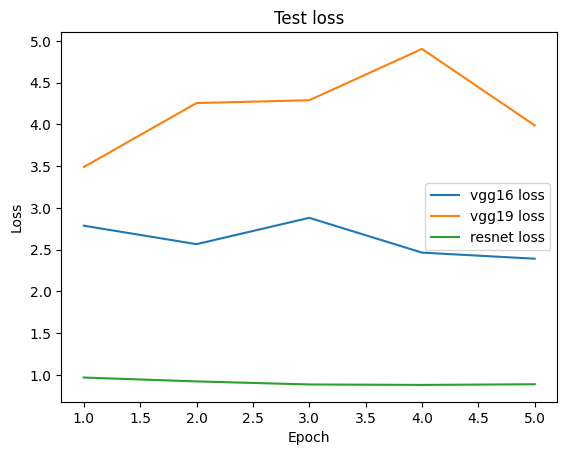

In [25]:
vgg16_accuracy = vgg16_history.history['val_accuracy']
vgg16_loss = vgg16_history.history['val_loss']
vgg19_accuracy = vgg19_history.history['val_accuracy']
vgg19_loss = vgg19_history.history['val_loss']
resnet_accuracy = resnet_history.history['val_accuracy']
resnet_loss = resnet_history.history['val_loss']

plt.plot(range(1, len(vgg16_loss) + 1), vgg16_loss, label='vgg16 loss')
plt.plot(range(1, len(vgg19_loss) + 1), vgg19_loss, label='vgg19 loss')
plt.plot(range(1, len(resnet_loss) + 1), resnet_loss, label='resnet loss')
plt.title('Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

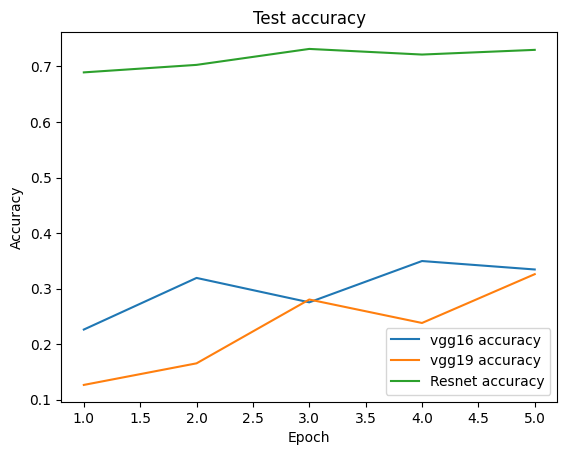

In [27]:
plt.plot(range(1, len(vgg16_accuracy) + 1), vgg16_accuracy, label='vgg16 accuracy')
plt.plot(range(1, len(vgg19_accuracy) + 1), vgg19_accuracy, label='vgg19 accuracy')
plt.plot(range(1, len(resnet_accuracy) + 1), resnet_accuracy, label='Resnet accuracy')
plt.title('Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [32]:
classes_dogs_vs_cats=os.listdir(folder_data_cats_vs_dogs_name); classes_count_dogs_vs_cats=len(classes_dogs_vs_cats)

x_dogs_vs_cats = []
y_dogs_vs_cats = []
for i, folder_name in enumerate(classes):
	folder_current=f"{folder_data_cats_vs_dogs_name}/{folder_name}"
	for file_name in os.listdir(folder_current):
		x_dogs_vs_cats.append(keras.preprocessing.image.img_to_array(keras.preprocessing.image.load_img(f"{folder_current}/{file_name}", target_size=image_size))/255.0)
		y_dogs_vs_cats.append(i)

x_train_dogs_vs_cats, x_test_dogs_vs_cats, y_train_dogs_vs_cats, y_test_dogs_vs_cats = train_test_split(np.array(x_dogs_vs_cats), np.array(y_dogs_vs_cats), test_size=0.2, stratify=y_dogs_vs_cats, random_state=10)

In [33]:
model = keras.models.Sequential(
	[
		keras.applications.ResNet50V2(include_top=False, input_shape=(image_size[0], image_size[1], 3), pooling='avg', classes=classes_count_dogs_vs_cats),
		keras.layers.Flatten(),
		keras.layers.Dropout(0.5),
		keras.layers.Dense(1, activation='sigmoid')
	]
)
model.layers[0].trainable = False
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ ?                      │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,564,800 (89.89 MB)

In [26]:
model.fit(x_train_dogs_vs_cats, y_train_dogs_vs_cats, epochs = 1, validation_split = 0.1)

221/221 ━━━━━━━━━━━━━━━━━━━━ 84s 355ms/step - accuracy: 0.6992 - loss: 0.9150 - val_accuracy: 0.7258 - val_loss: 0.5052


In [ ]:
loss, accuracy = model.evaluate(x_test)
print("Test loss: ", loss)
print("Test accuracy: ", accuracy)

Матрица ошибок

47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 528ms/step


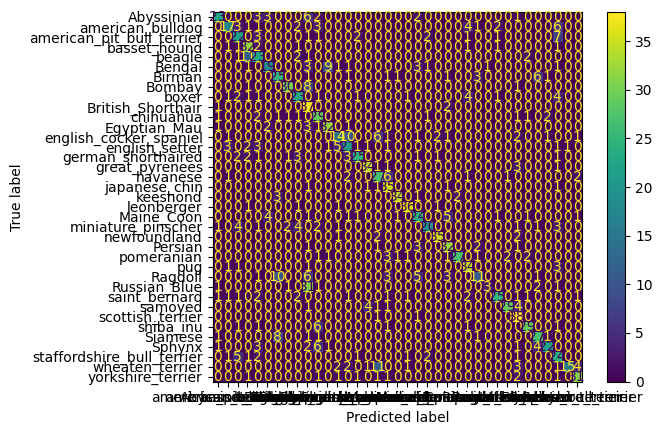

In [39]:
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test.argmax(axis=1), resnet.predict(x_test).argmax(axis=1)), display_labels=classes).plot()

In [41]:

print("Top 3 accuracy: ", metrics.top_k_accuracy_score(y_test.argmax(axis=1), resnet.predict(x_test), k=3))
print("Top 3 accuracy: ", metrics.top_k_accuracy_score(y_test.argmax(axis=1), resnet.predict(x_test), k=5))

47/47 ━━━━━━━━━━━━━━━━━━━━ 24s 519ms/step
Top 3 accuracy:  0.8755074424898511
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 531ms/step
Top 3 accuracy:  0.9282814614343707


### GradCam

Freeing resources

In [8]:
import gc
del x
del y
del resnet_history
gc.collect()

721

Found 7390 files belonging to 37 classes.


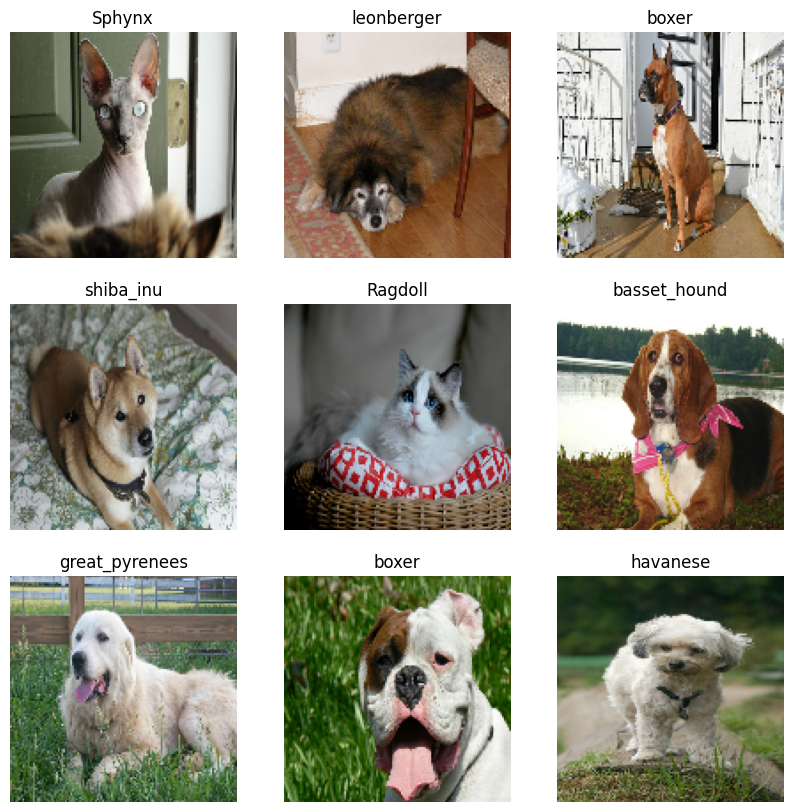

In [83]:
dataset_test = keras.utils.image_dataset_from_directory(folder_data_breeds_name, seed = 13, image_size = image_size, batch_size = batch_size)
x_test_list = []
y_test_list = []
batches_count=0
for x, y in dataset_test:
	x_test_list.append(x)
	y_test_list.append(y)
	batches_count+=1
	if(batches_count==1):
		break
	
x_test_list=np.concatenate(x_test_list)
display_images(dataset_test, classes)

In [134]:
def getGradCam(model, image, class_index, layer_name):
	model_gradient = keras.Model(model.inputs, [model.get_layer(layer_name).output, model.output])
	
	with tf.GradientTape() as tape:
		output, predictions = model_gradient(image)
		loss = predictions[:, class_index]
	heatmap = np.maximum(tf.reduce_mean(tf.multiply(output[0], tf.reduce_mean(tape.gradient(loss, output), axis=(0, 1, 2))), axis=-1), 0)
	heatmap /= np.max(heatmap)

	return heatmap

C:\Users\Root\AppData\Local\Temp\ipykernel_8128\2904681690.py:8: RuntimeWarning: invalid value encountered in divide
  heatmap /= np.max(heatmap)
C:\Users\Root\AppData\Local\Temp\ipykernel_8128\4193636683.py:7: RuntimeWarning: invalid value encountered in cast
  heatmap = jet(np.array(PIL.Image.fromarray((getGradCam(resnet, image, class_index, layer_name) * 255).astype(np.uint8)).resize(image_size)) / 255.0)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


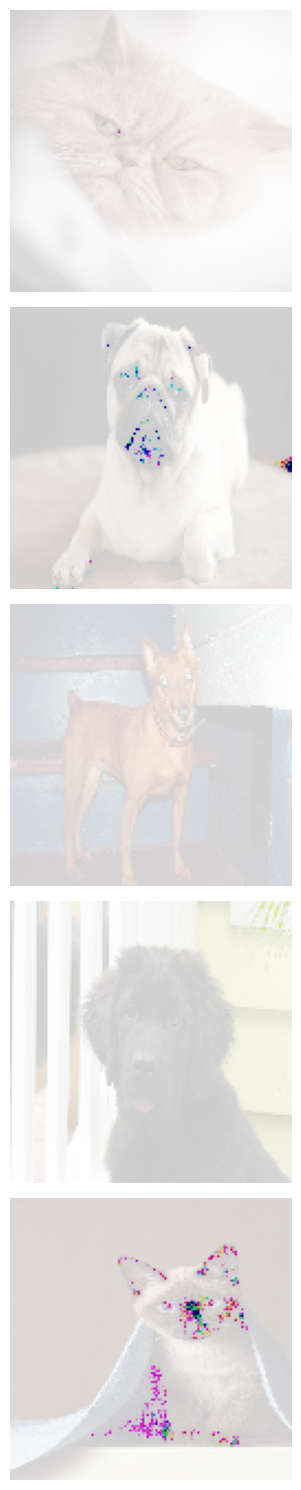

In [138]:
layer_name = 'conv5_block3_2_conv'
rows, cols=5, 1
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
for i, image_index in enumerate(np.random.randint(0, len(x_test_list), size=rows)):
	image = np.expand_dims(x_test_list[image_index], axis=0)
	for j, class_index in enumerate(np.random.randint(0, classes_count, size=cols)):
		heatmap = jet(np.array(PIL.Image.fromarray((getGradCam(resnet, image, class_index, layer_name) * 255).astype(np.uint8)).resize(image_size)) / 255.0)
		heatmap = heatmap[:, :, :3]

		axes[i].imshow((heatmap+image[0]))  
		axes[i].imshow((heatmap+image[0]).astype(int), alpha=0.2)  
		axes[i].axis('off')
		
plt.tight_layout()
plt.show()